# Food Vision

**Project Description:** The Food Vision Project is an exciting initiative in the field of computer vision, leveraging the power of TensorFlow, a popular open-source machine learning library. This project was introduced during the TensorFlow developer course, offering participants a hands-on experience in developing and deploying a sophisticated image recognition model. The primary objective of the project is to accurately predict the identity of various food items from a set of **101** predefined categories using machine learning algorithms.

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow as tf
import tensorflow_datasets as tfds

## Use TensorFlow to Download The Data

To begin building a model, we strat downloading the data. The data that we are going to use is from TensorFlow dataset named `food101`

In [2]:
# Get all available datasets in TF-DS
dataset_list = tfds.list_builders()

# set the target and see if exists
target_dataset = "food101"
print(f"{target_dataset} is in TensorFlow datasets: {target_dataset in dataset_list}")

food101 is in TensorFlow datasets: True


Nice! It looks like the data that we are looking for is existed. Next, we are going to load the data using `tfds.load()`.

In [3]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name=target_dataset,
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8GVI2Q/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8GVI2Q/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
# Features in the dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [5]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Data Explorations

Let's find out a few details about the dataset:

* The shape of the input data (image tensors)
* The datatype of the input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

Let's take one sample from the train data using `take()` functions.

In [6]:
# take one sample from the train data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
# Info about our train one sample data
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class: 74
  Class name: peking_duck
  


In [8]:
# What does our image tensor look like?
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[152, 129,  77],
        [160, 137,  85],
        [160, 137,  85],
        ...,
        [ 26,  21,  18],
        [ 24,  19,  16],
        [ 21,  16,  13]],

       [[156, 133,  81],
        [158, 135,  83],
        [155, 132,  80],
        ...,
        [ 25,  20,  17],
        [ 23,  18,  15],
        [ 22,  17,  14]],

       [[164, 141,  87],
        [159, 136,  82],
        [147, 124,  70],
        ...,
        [ 23,  18,  15],
        [ 21,  17,  14],
        [ 20,  16,  13]],

       ...,

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 26,  14,  16],
        [ 26,  14,  16],
        [ 32,  20,  22]],

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 24,  14,  15],
        [ 30,  18,  18],
        [ 30,  18,  18]],

       [[  2,  50, 122],
        [  0,  48, 120],
        [  0,  48, 120],
        ...,
        [ 22,  12,  1

In [9]:
# what is the min and max values?
tf.reduce_min(image.numpy()), tf.reduce_max(image.numpy())

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network.

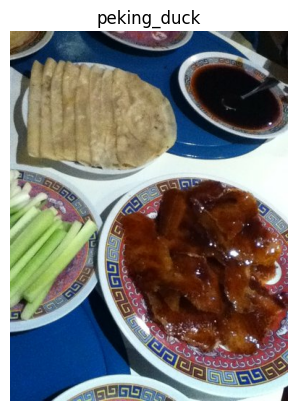

In [10]:
# plot the image from teh data
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create Functions to Preprocess The Data

Our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using `tf.image.resize()`
* Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()`

In [11]:
# make a function for preprocessing images
def preprocess_img(image, label, image_shape=224):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshape
  image to [image_shape, image_shape, image_color]
  """
  image = tf.image.resize(image, [image_shape, image_shape])
  return tf.cast(image, tf.float32), label

In [12]:
# preprocessing a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...\nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[152 129  77]
  [160 137  85]
  [160 137  85]
  ...
  [ 26  21  18]
  [ 24  19  16]
  [ 21  16  13]]

 [[156 133  81]
  [158 135  83]
  [155 132  80]
  ...
  [ 25  20  17]
  [ 23  18  15]
  [ 22  17  14]]]...
Shape: (512, 384, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[156.05103  133.05103   81.05102 ]
  [156.13776  133.13776   81.13776 ]
  [146.31122  123.311226  71.311226]
  ...
  [ 22.454105  17.454105  13.668401]
  [ 25.306135  20.306135  17.306135]
  [ 22.25511   17.25511   14.25511 ]]

 [[159.82652  136.82652   82.82653 ]
  [149.79591  126.79591   72.79591 ]
  [132.69388  109.69388   57.26531 ]
  ...
  [ 24.183672  19.183672  15.397966]
  [ 22.21425   17.21425   14.214251]
  [ 18.83164   14.83164   11.83164 ]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


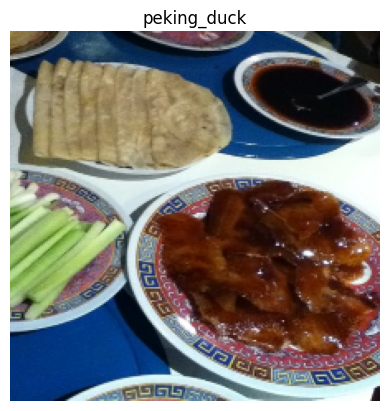

In [13]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

The input images got converted from `unit8` to `float32` and got reshaped to `(224, 224, 3)`

## Batch and Prepare Dataset

Before we can model the data, we will turn the data into batches.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

We're going to through things in following order:

```original dataset -> map() -> shuffle() -> batch -> prefetch() -> PrefetchDataset```



In [14]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to testing data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn the test data into batches 32
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# Check the data looks like
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creat Modelling Callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

In [16]:
import datetime
def create_tensorboard_callbacks(dir_name, experiment_name):
  """
  Create a tensorboard callbacks instand to store log files

  Stores log files with the filepath:
  "dir_name/experiment_name/current_datetime/"

  Args:
  dir_name: target directory to store log files
  experiment_name: name of experiment directory
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

In [17]:
# Create ModelCheckpoint to save model progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weight requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup Mixed Precision Training

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

For tensors in float16 format, each element occupies 16 bits in computer memory. So it will make our training process faster than before.

In [18]:
# Turn on Mixed Precision Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [19]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build a Feature Extraction Model

To build the feature extraction mmodel, we'll:
* Use EfficientNetB0 from tf.keras.applications pre-trained on ImageNet as our base model
  - We'll download this without the top layers using include_top=False parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a Functional model
* Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

In [20]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [21]:
# check the model layer
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

### Checking Layer `dtype` Polices

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [22]:
# check the dtype policy attributes of layers in the model
for layer in model.layers:
  print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

input_layer float32 True <Policy "float32">
efficientnetb0 float32 False <Policy "mixed_float16">
pooling_layer float32 True <Policy "mixed_float16">
dense float32 True <Policy "mixed_float16">
softmax_float32 float32 True <Policy "float32">


We see:
* `layer.name`: a layer's name.
* `layer.trainable`: wheter or not your layer will be trainable.
* `layer.dtype`: the data type a layer stores in its variable in.
* `layer.dtype_policy`: the data type a layer computes in

In [23]:
# check the layer's base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

input_1 float32 False <Policy "float32">
rescaling float32 False <Policy "mixed_float16">
normalization float32 False <Policy "mixed_float16">
rescaling_1 float32 False <Policy "mixed_float16">
stem_conv_pad float32 False <Policy "mixed_float16">
stem_conv float32 False <Policy "mixed_float16">
stem_bn float32 False <Policy "mixed_float16">
stem_activation float32 False <Policy "mixed_float16">
block1a_dwconv float32 False <Policy "mixed_float16">
block1a_bn float32 False <Policy "mixed_float16">
block1a_activation float32 False <Policy "mixed_float16">
block1a_se_squeeze float32 False <Policy "mixed_float16">
block1a_se_reshape float32 False <Policy "mixed_float16">
block1a_se_reduce float32 False <Policy "mixed_float16">
block1a_se_expand float32 False <Policy "mixed_float16">
block1a_se_excite float32 False <Policy "mixed_float16">
block1a_project_conv float32 False <Policy "mixed_float16">
block1a_project_bn float32 False <Policy "mixed_float16">
block2a_expand_conv float32 False <

## Fit The Feature Extraction Model

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [24]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callbacks("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to training_logs/efficientnetb0_101_classes_all_data_feature_extract/20231130-040508
Epoch 1/3
2368/2368 [==============================] - 229s 86ms/step - loss: 1.7167 - accuracy: 0.5843 - val_loss: 1.1201 - val_accuracy: 0.7021
Epoch 2/3
2368/2368 [==============================] - 190s 79ms/step - loss: 1.1991 - accuracy: 0.6900 - val_loss: 1.0240 - val_accuracy: 0.7188
Epoch 3/3
2368/2368 [==============================] - 196s 82ms/step - loss: 1.0536 - accuracy: 0.7243 - val_loss: 0.9920 - val_accuracy: 0.7227


In [25]:
# evaluate the model
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 56s 71ms/step - loss: 0.9963 - accuracy: 0.7293


[0.9962538480758667, 0.7292672991752625]

Since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

## Load and Evaluate Checkpoin Weights

We can load in and evaluate the model checkpoint by:
1. Recreating a new instance of our model called `created_model` by turning our original model creation code into a function called `create_model()`.
2. Compiling our `created_model` with the same loss, optimizer and metrics as the original model (every time you create a new model, you must compile it).
3. Calling the `load_weights()` method on our created_model and passing it the path to where our checkpointed weights are stored.
4. Calling `evaluate()` on created_model with loaded weights and saving the results.
5. Comparing the `created_model` results to our previous model results (these should be the exact same, if not very close).

In [26]:
# 1. create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 59s 71ms/step - loss: 0.9963 - accuracy: 0.7293


In [27]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

Cloning the model preserves dtype_policy's of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning our created_model, we could and it would still use the mixed precision dtype policy.

## Save The Whole Model

We can also save the whole model using the `save()` method.

We save it directly in Google Colab. In this case, I'm using google colab for this project

In [28]:
# save model locally to google colab
save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [29]:
# load in and evaluate the saved model
load_saved_model = tf.keras.models.load_model(save_dir)

In [30]:
# check the saved model performance
result_saved_model = load_saved_model.evaluate(test_data)
result_saved_model

790/790 [==============================] - 58s 71ms/step - loss: 0.9963 - accuracy: 0.7293


[0.9962550401687622, 0.7292672991752625]

With the feature-extraction model we got good enough accuracy. But it is not enough yet since we got only 72%. We can raise this score by using another method. Next, we are going to use fine-tuning model.

## Preparing The Model's Layers for Fine-Tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Since we are using the last model we created, so we are loading in the model.

In [31]:
# load in the model
load_fe_model = tf.keras.models.load_model("/content/efficientnetb0_feature_extract_model_mixed_precision")

In [32]:
# get summary from the model
load_fe_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [33]:
# how does the loaded model perform
results_loaded_saved_model = load_fe_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 58s 71ms/step - loss: 0.9963 - accuracy: 0.7293


[0.9962540864944458, 0.7292672991752625]

In [34]:
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

The model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [35]:
# Are any layers in the model frozen?
for layer in load_fe_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


It looks like the layers is frozen. Let's get into the deeper of our base model.

In [36]:
# check layers in base model and dtype policy they're using
for layer in load_fe_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
rescaling_1 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float

Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy `mixed_policy16` is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

## A Couple More Callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

For this case we are going to use `EarlyStopping`. Using the EarlyStopping callback combined with the ModelCheckpoint callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

We are also going to use `ReduceLROnPlateu` callback monitors a specified metric when that metric stops imporiving, it reduces the learing rate with specified factors.

In [37]:
# Setup EarlyStopping to stop the model training if the model is not improving for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # we only see the val loss
                                                  patience=3)  # if the model performance is decrase in 3 epochs, the training stops

# create model checkpoint to save only best model during fine-tuning
save_dir = "fine_tuned_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir,
                                                      monitor="val_loss",
                                                      save_best_only=True)

# create ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [38]:
# compile the model
load_fe_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(0.0001),
                      metrics=["accuracy"])

The model is compiled. It's time to fit the model with the data and we are going to use 100 epochs. Since we are using `EarlyStopping`, the model will stop before 100 epochs.

In [39]:
# start fine-tuned with all layers
history_101_all_data_fine_tuned = load_fe_model.fit(train_data,
                                                epochs=100,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=int(0.15*len(test_data)),
                                                callbacks=[create_tensorboard_callbacks("training_logs", "efficientnetb0_fine_tuned"),
                                                          model_checkpoint,
                                                          early_stopping,
                                                          reduce_lr])

Saving TensorBoard log files to training_logs/efficientnetb0_fine_tuned/20231130-042115
Epoch 1/100
2368/2368 [==============================] - 476s 183ms/step - loss: 0.8693 - accuracy: 0.7656 - val_loss: 0.8004 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 415s 174ms/step - loss: 0.5346 - accuracy: 0.8528 - val_loss: 0.7211 - val_accuracy: 0.8099 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 380s 159ms/step - loss: 0.3033 - accuracy: 0.9137 - val_loss: 0.7901 - val_accuracy: 0.7926 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9541
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 363s 152ms/step - loss: 0.1566 - accuracy: 0.9541 - val_loss: 0.9335 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 359s 150ms/step - loss: 0.0

It looks like our model is overfitting. Because our training loss is significantly lower than validation loss. It means that our model did not learn generalizable patterns to unssen data.

## Save The Fine-Tuned Model (again)

In [45]:
# save the model locally if you use google colab
load_fe_model.save("efficientB0_fine_tuned_mixed_precision")

## Load The Fine-Tuned Model

In [ ]:
# Load and evaluate the model
load_fine_tuned_model = tf.keras.models.load_model("/content/efficientB0_fine_tuned_mixed_precision")

In [44]:
# See the model summary (the model summary)
load_fine_tuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

It got same architecture as the model above. Now, let's evaluate the model. Because in the last model we just see the performance used only 15% of test data, now we are going to use the whole test data.

In [46]:
# see the model performance
result_fine_tuned_model = load_fine_tuned_model.evaluate(test_data)
result_fine_tuned_model

790/790 [==============================] - 56s 71ms/step - loss: 1.0272 - accuracy: 0.8035


[1.027190923690796, 0.8035247325897217]

## Conclusion
- Using TensorFlow dataset. We trained more than 2000 food images and tested the model using 790 food images.
- Making feature extaction model, we got 72% for the accruacy whether for training or for testing.
- We unfreeze the layer it means we updated the layers in feature extraction. And we get a better result 80% for data testing.

Now our model is perfoming better. But, there is something that we can improve the loss and the accuracy.

To fix this, in the future experiment, we might do this:
* A different iteration of EfficientNet (e.g. EfficientNetB4 instead of EfficientNetB0).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.
* Use the same evaluation technique called Scalling Up.